Shape: (303, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


Shape after preprocessing: (303, 28)


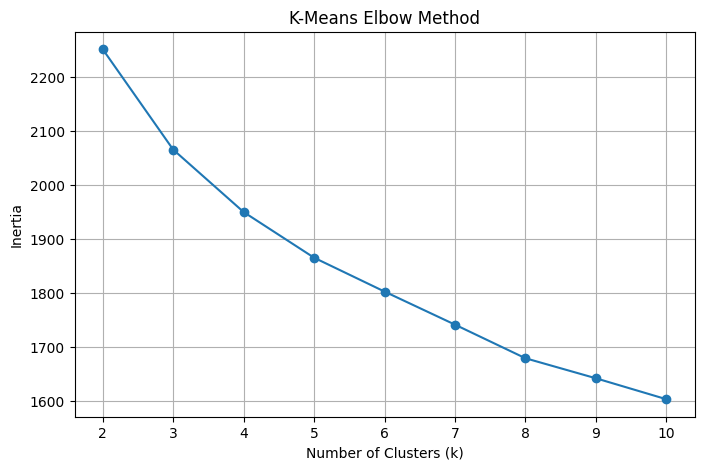

Silhouette Score for k=2: 0.165
Adjusted Rand Index vs true labels: 0.273


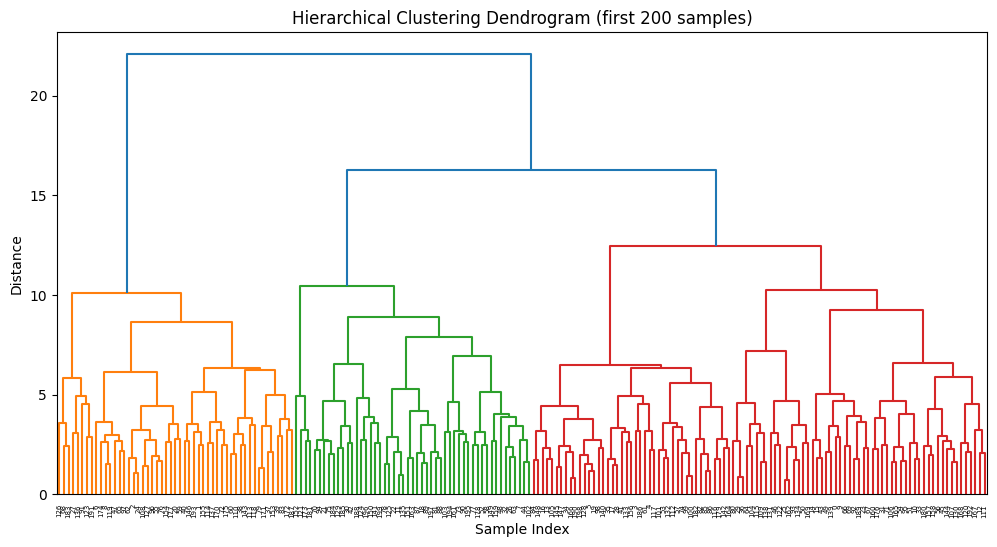

Silhouette Score (Hierarchical, k=2): 0.157
Adjusted Rand Index vs true labels (Hierarchical): 0.219
Clustering results saved to ../results/clustering_results.csv


In [3]:
# ============================================================
# 05_unsupervised_learning.ipynb
# K-Means and Hierarchical Clustering on Heart Disease dataset
# ============================================================

# ---- Cell 1: Imports ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage

# ---- Cell 2: Load cleaned dataset ----
df = pd.read_csv('../results/cleaned_heart.csv')
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# ---- Cell 3: Separate features and target ----
target_col = 'num'
X = df.drop(columns=[target_col])
y = df[target_col]

# Explicit numeric and categorical columns
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# ---- Cell 4: Preprocessing pipeline ----
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Preprocess the whole dataset
X_preprocessed = preprocessor.fit_transform(X)
print("Shape after preprocessing:", X_preprocessed.shape)

# ---- Cell 5: K-Means Elbow Method ----
inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_preprocessed)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('K-Means Elbow Method')
plt.grid(True)
plt.show()

# ---- Cell 6: K-Means with chosen k ----
optimal_k = 2  # Based on elbow, adjust if needed
km = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_kmeans = km.fit_predict(X_preprocessed)

sil_score = silhouette_score(X_preprocessed, labels_kmeans)
print(f"Silhouette Score for k={optimal_k}: {sil_score:.3f}")

ari_kmeans = adjusted_rand_score(y, labels_kmeans)
print(f"Adjusted Rand Index vs true labels: {ari_kmeans:.3f}")

# ---- Cell 7: Hierarchical Clustering ----
linkage_matrix = linkage(X_preprocessed[:200], method='ward')  # subset for speed
plt.figure(figsize=(12,6))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram (first 200 samples)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# Fit AgglomerativeClustering with same number of clusters
hc = AgglomerativeClustering(n_clusters=optimal_k)
labels_hc = hc.fit_predict(X_preprocessed)

sil_score_hc = silhouette_score(X_preprocessed, labels_hc)
print(f"Silhouette Score (Hierarchical, k={optimal_k}): {sil_score_hc:.3f}")

ari_hc = adjusted_rand_score(y, labels_hc)
print(f"Adjusted Rand Index vs true labels (Hierarchical): {ari_hc:.3f}")

# ---- Cell 8: Save clustering results ----
df_kmeans = df.copy()
df_kmeans['cluster_kmeans'] = labels_kmeans
df_kmeans['cluster_hierarchical'] = labels_hc

df_kmeans.to_csv('../results/clustering_results.csv', index=False)
print("Clustering results saved to ../results/clustering_results.csv")
